<a href="https://colab.research.google.com/github/Krupa-varshini/OIBGRIP/blob/main/internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

   Index      Customer Id First Name Last Name                      Company  \
0      1  dE014d010c7ab0c     Andrew   Goodman                Stewart-Flynn   
1      2  2B54172c8b65eC3      Alvin      Lane  Terry, Proctor and Lawrence   
2      3  d794Dd48988d2ac      Jenna   Harding                 Bailey Group   
3      4  3b3Aa4aCc68f3Be   Fernando      Ford                 Moss-Maxwell   
4      5  D60df62ad2ae41E       Kara     Woods              Mccarthy-Kelley   

               City           Country                Phone 1  \
0       Rowlandberg             Macao      846-790-4623x4715   
1          Bethside  Papua New Guinea     124-597-8652x05682   
2      Moniquemouth             China     (335)987-3085x3780   
3        Leeborough             Macao          (047)752-3122   
4  Port Jacksonland             Nepal  +1-360-693-4419x19272   

               Phone 2                          Email Subscription Date  \
0  (422)787-2331x71127  marieyates@gomez-spencer.info        2021

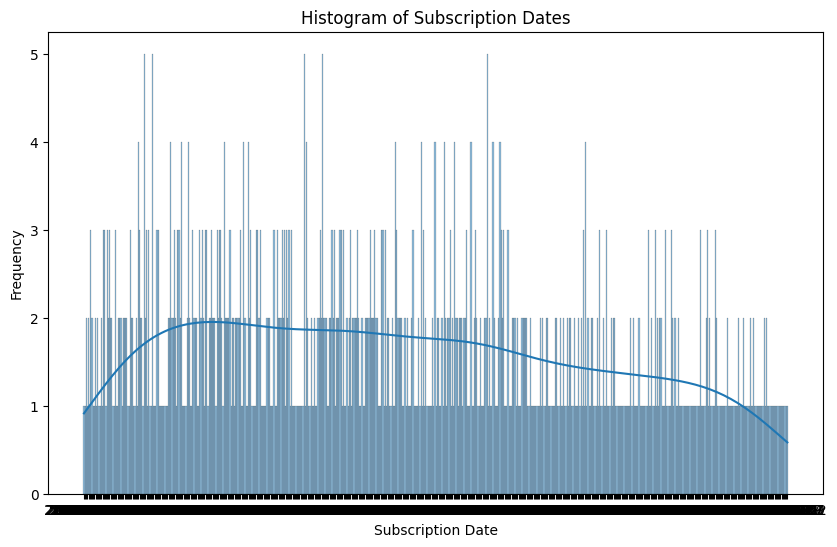

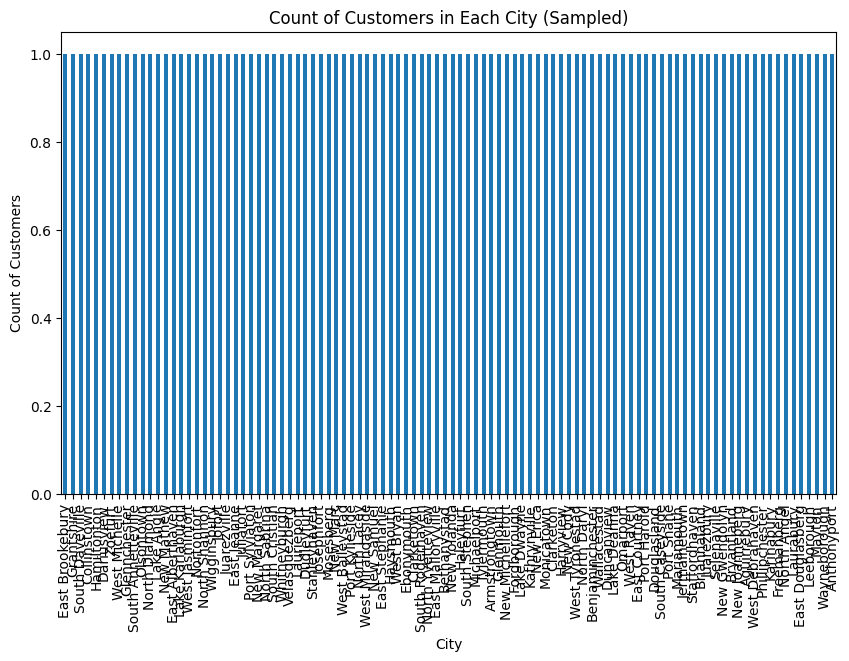

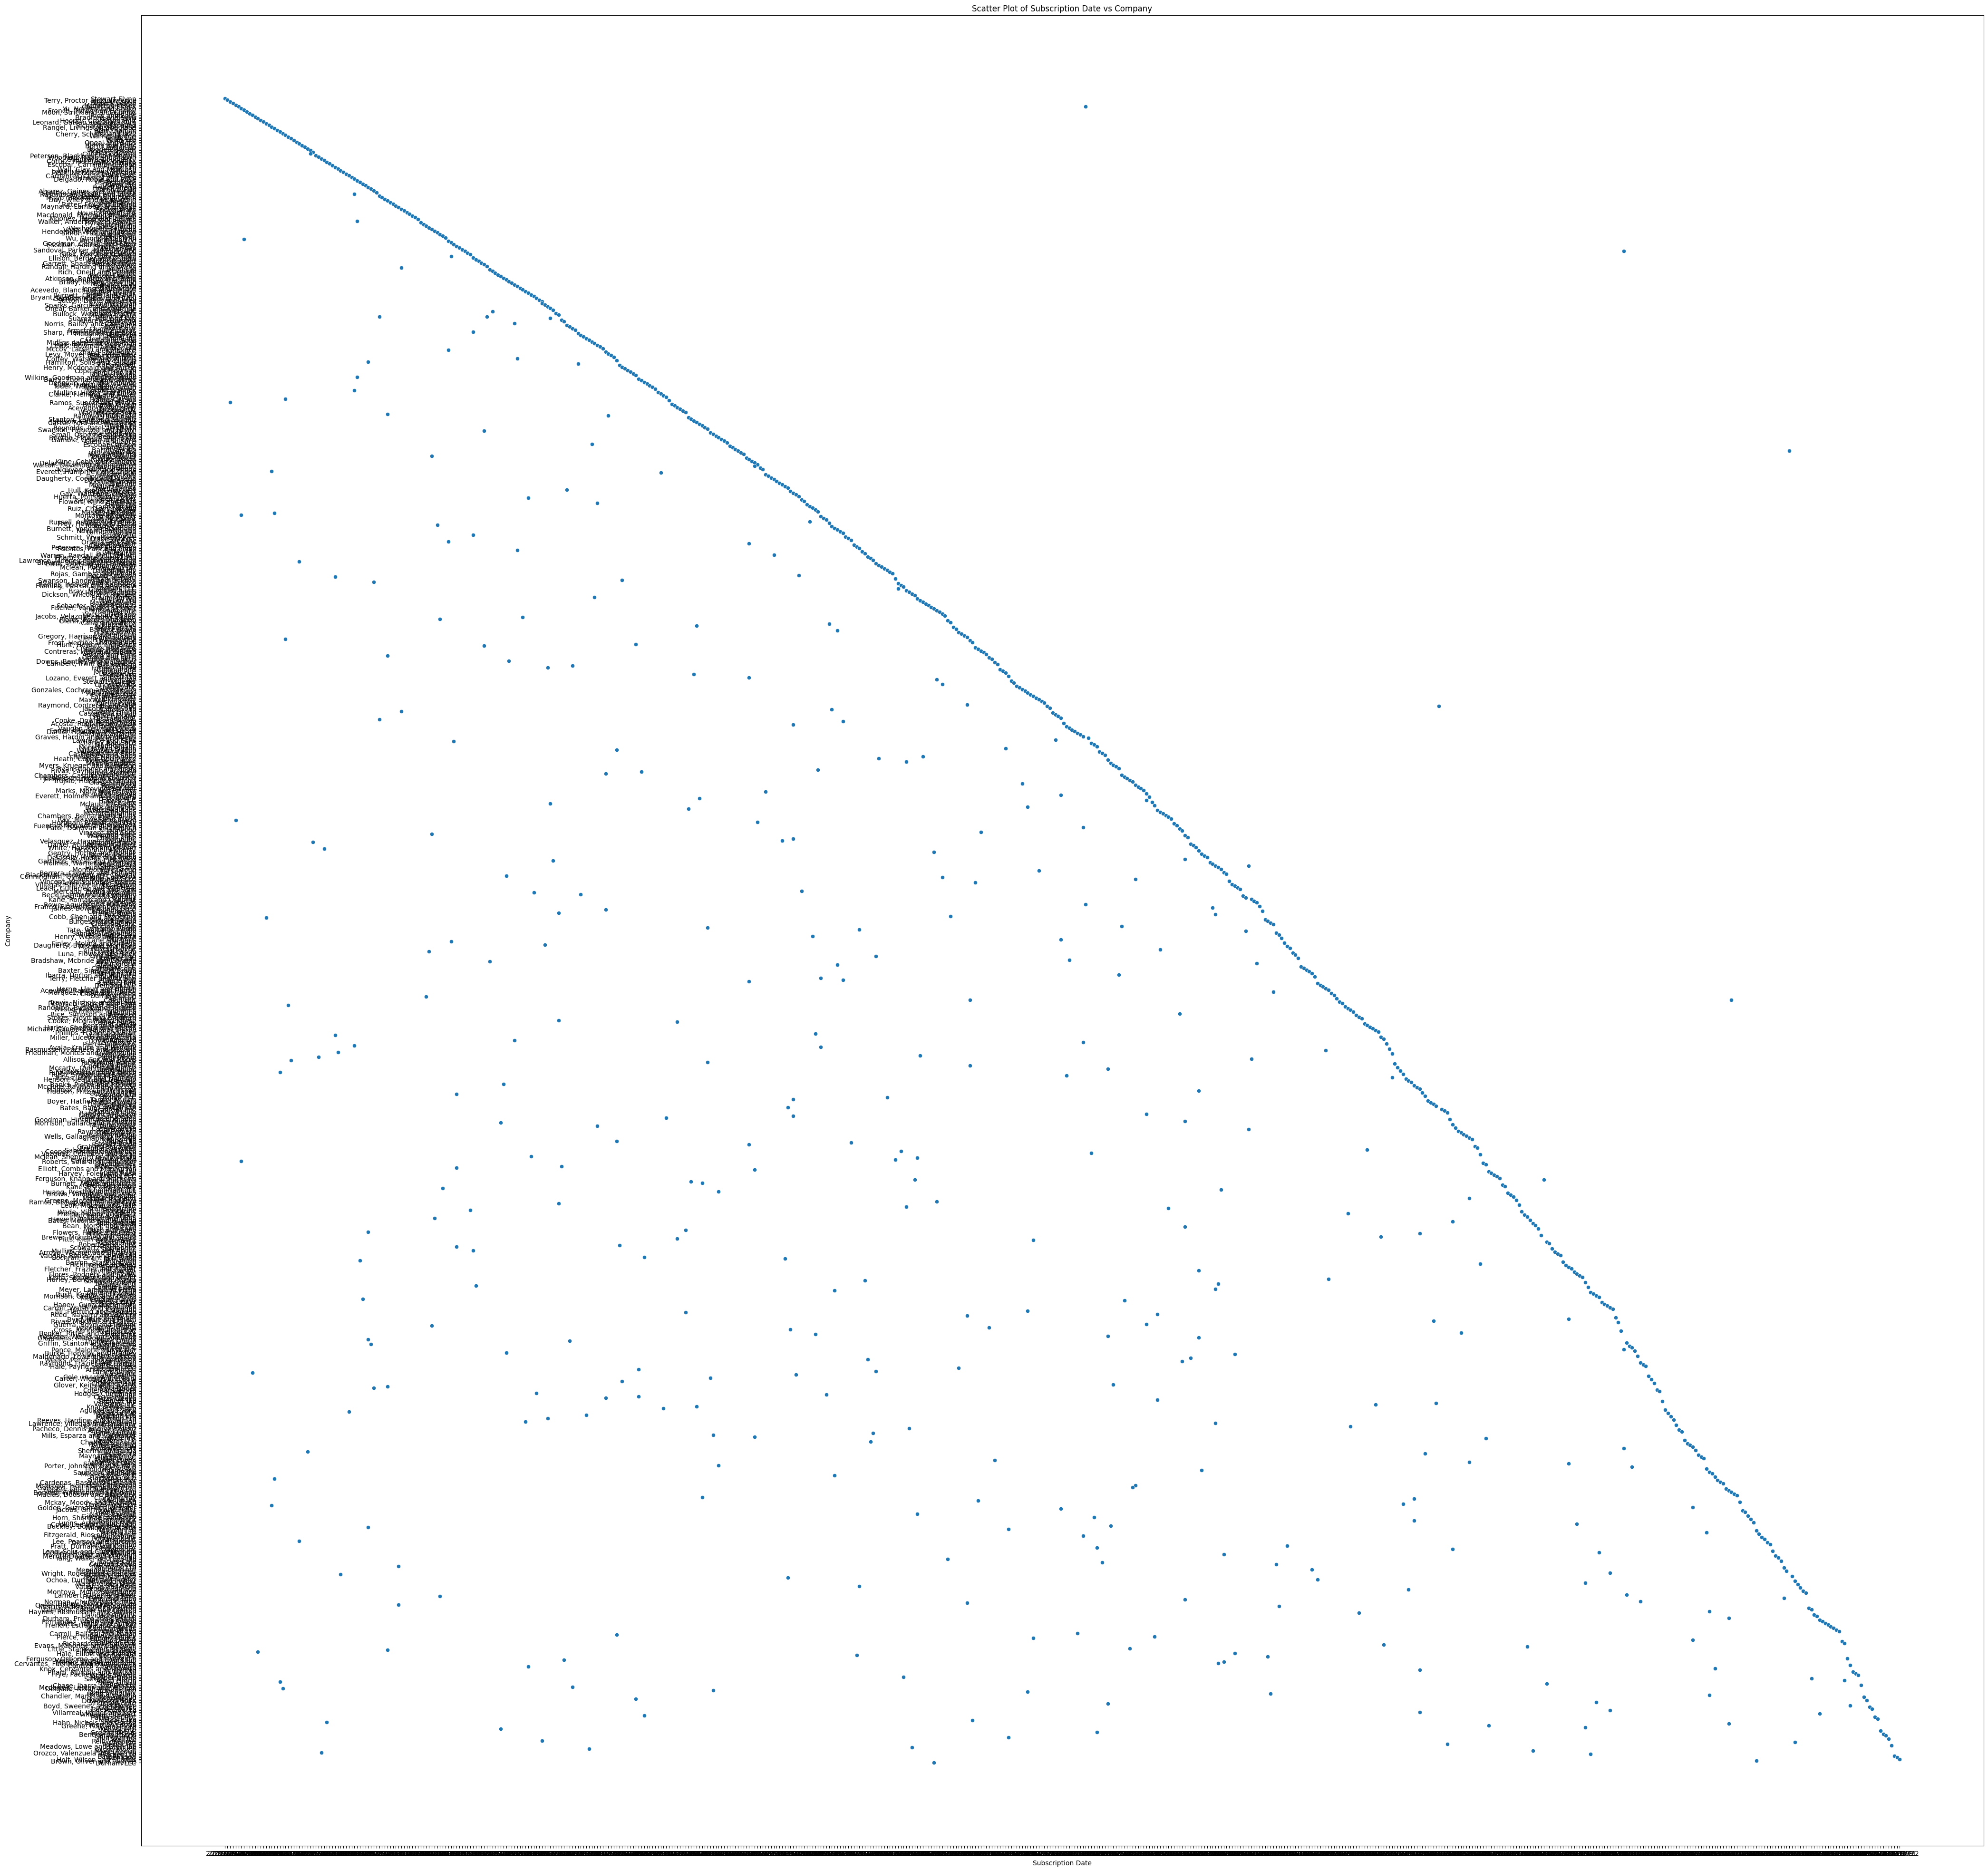

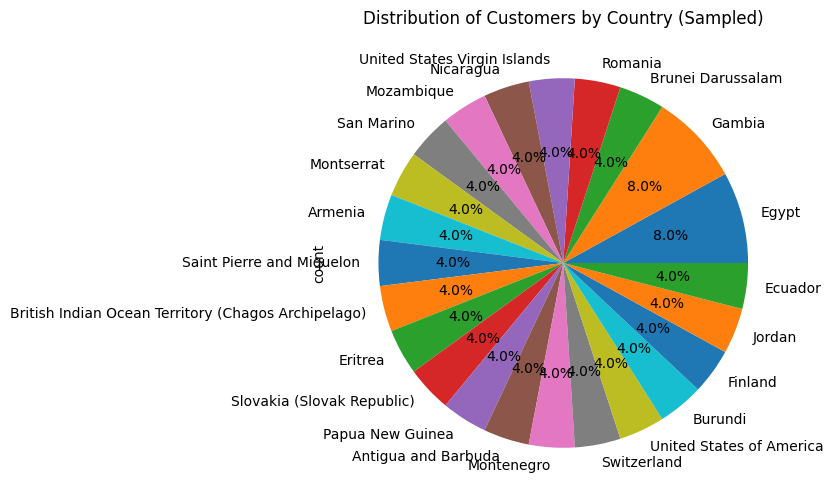

Class distribution in the full dataset:
HasPhone2
1    1000
Name: count, dtype: int64
All entries have 'Phone 2'. The 'HasPhone2' column will always be 1.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
try:
    data = pd.read_csv('/content/customers-1000.csv')
except FileNotFoundError:
    print("Error: The file 'customers-1000.csv' was not found.")
    exit()

# Explore the dataset
print(data.head())  # Show the first few rows of the dataset
print(data.info())  # Show information about the dataset
print(data.describe())  # Show summary statistics of the dataset

# Handle missing values
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].mean())

# Data Visualization
# Histogram of Subscription Dates
plt.figure(figsize=(10, 6))
sns.histplot(data['Subscription Date'], kde=True, bins=30)
plt.title('Histogram of Subscription Dates')
plt.xlabel('Subscription Date')
plt.ylabel('Frequency')
plt.show()

# Sample 100 data points
sample_data = data.sample(100)

# Bar chart: Count of customers in each city
city_counts = sample_data['City'].value_counts()
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar')
plt.title('Count of Customers in Each City (Sampled)')
plt.xlabel('City')
plt.ylabel('Count of Customers')
plt.show()

# Scatter plot of Subscription Date vs Company
plt.figure(figsize=(50, 50))
sns.scatterplot(x=data['Subscription Date'], y=data['Company'])
plt.title('Scatter Plot of Subscription Date vs Company')
plt.xlabel('Subscription Date')
plt.ylabel('Company')
plt.show()

# Sample 100 data points
sample_data = data.sample(25)

# Pie chart: Distribution of customers by country
country_counts = sample_data['Country'].value_counts()
plt.figure(figsize=(8, 6))
country_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Customers by Country (Sampled)')
plt.show()

# Feature Engineering
# Create a new feature 'CityGroup' based on frequency of 'City' column
top_cities = data['City'].value_counts().head(10).index
data['CityGroup'] = data['City'].apply(lambda x: x if x in top_cities else 'Other')

# Create a proxy target variable 'HasPhone2'
data['HasPhone2'] = data['Phone 2'].notnull().astype(int)

# Check for class balance in HasPhone2
print("Class distribution in the full dataset:")
print(data['HasPhone2'].value_counts())

# If there are no missing values, 'HasPhone2' will always be 1
if data['HasPhone2'].nunique() == 1:
    print("All entries have 'Phone 2'. The 'HasPhone2' column will always be 1.")
else:
    # Ensure the target variable has balanced classes before splitting
    class_0 = data[data['HasPhone2'] == 0]
    class_1 = data[data['HasPhone2'] == 1]

    # Balance the dataset by sampling
    min_samples = min(len(class_0), len(class_1))
    class_0 = class_0.sample(min_samples, random_state=42)
    class_1 = class_1.sample(min_samples, random_state=42)

    balanced_data = pd.concat([class_0, class_1])

    print(f"Balanced data shape: {balanced_data.shape}")

    # Preparing data for modeling
    # Define features (X) and target (y)
    X = balanced_data.drop(['Customer Id', 'First Name', 'Last Name', 'Company', 'Phone 2', 'Email', 'Subscription Date', 'Website', 'HasPhone2'], axis=1)
    y = balanced_data['HasPhone2']

    # Check if X and y are not empty before splitting
    if not X.empty and not y.empty:
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Check class distribution in training set
        print("Class distribution in the training set:")
        print(y_train.value_counts())

        # Preprocessing and modeling pipeline
        numeric_features = X.select_dtypes(include=[np.number]).columns
        categorical_features = X.select_dtypes(exclude=[np.number]).columns

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
            ])

        # Example: Logistic Regression model
        model = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression())
        ])

        # Train the model
        model.fit(X_train, y_train)

        # Predict on test data
        y_pred = model.predict(X_test)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1-Score: {f1}")

        # Cross-validation scores
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
        print(f"Cross-validation accuracy: {cv_scores.mean()}")
    else:
        print("Error: The dataset is empty after balancing.")